# Goal

The objective of this notebook is to demonstrate and visualize the computation of the pareto frontier.

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
import pandas as pd


from mlos.OptimizerEvaluationTools.ObjectiveFunctionFactory import ObjectiveFunctionFactory
from mlos.OptimizerEvaluationTools.SyntheticFunctions.Hypersphere import Hypersphere

from mlos.Optimizers.BayesianOptimizerFactory import BayesianOptimizerFactory, bayesian_optimizer_config_store
from mlos.Optimizers.OptimizationProblem import OptimizationProblem, Objective
from mlos.Optimizers.ParetoFrontier import ParetoFrontier

from mlos.Spaces import ContinuousDimension, DiscreteDimension, Point, SimpleHypergrid

hypersphere_radius = 10

objective_function_config = Point(
    implementation=Hypersphere.__name__,
    hypersphere_config=Point(
        num_objectives=2,
        minimize='none',
        radius=hypersphere_radius
    )
)

objective_function = ObjectiveFunctionFactory.create_objective_function(objective_function_config=objective_function_config)
optimization_problem = objective_function.default_optimization_problem
optimizer = BayesianOptimizerFactory().create_local_optimizer(
    optimization_problem=optimization_problem
)

01/26/2021 01:40:20 -   BayesianOptimizerFactory -    INFO - [BayesianOptimizerFactory.py:  37 -    create_local_optimizer() ] Optimizer config not specified. Using default.
01/26/2021 01:40:20 -   BayesianOptimizerFactory -    INFO - [HomogeneousRandomForestRegressionModel.py: 106 -        _create_estimators() ] Creating 10 estimators. Tree config: {
  "criterion": "mse",
  "splitter": "best",
  "max_depth": 0,
  "min_samples_split": 2,
  "min_samples_leaf": 3,
  "min_weight_fraction_leaf": 0,
  "max_features": "auto",
  "max_leaf_nodes": 0,
  "min_impurity_decrease": 0,
  "ccp_alpha": 0,
  "min_samples_to_fit": 10,
  "n_new_samples_before_refit": 10
}. Request id: 0.45981798920228956
01/26/2021 01:40:20 -   BayesianOptimizerFactory -    INFO - [HomogeneousRandomForestRegressionModel.py: 120 -        _create_estimators() ] Creating DecissionTreeRegressionModel with the input_space:   Name: estimator_0_input_space
  Dimensions:
    contains_context: {False}
    spherical_coordinates___

01/26/2021 01:40:20 -   BayesianOptimizerFactory -    INFO - [HomogeneousRandomForestRegressionModel.py: 120 -        _create_estimators() ] Creating DecissionTreeRegressionModel with the input_space:   Name: estimator_9_input_space
  Dimensions:
    spherical_coordinates___theta0: [0.00, 1.57]
    spherical_coordinates___theta1: [0.00, 1.57]
    contains_context: {False}


In [3]:
optimizer.optimizer_config

{
  "surrogate_model_implementation": "HomogeneousRandomForestRegressionModel",
  "experiment_designer_implementation": "ExperimentDesigner",
  "min_samples_required_for_guided_design_of_experiments": 10,
  "homogeneous_random_forest_regression_model_config.n_estimators": 10,
  "homogeneous_random_forest_regression_model_config.features_fraction_per_estimator": 0.7,
  "homogeneous_random_forest_regression_model_config.samples_fraction_per_estimator": 0.7,
  "homogeneous_random_forest_regression_model_config.regressor_implementation": "DecisionTreeRegressionModel",
  "homogeneous_random_forest_regression_model_config.decision_tree_regression_model_config.criterion": "mse",
  "homogeneous_random_forest_regression_model_config.decision_tree_regression_model_config.splitter": "best",
  "homogeneous_random_forest_regression_model_config.decision_tree_regression_model_config.max_depth": 0,
  "homogeneous_random_forest_regression_model_config.decision_tree_regression_model_config.min_samples_

In [17]:
num_iterations = 200
for i in range(num_iterations):
    print(i)
    config = optimizer.suggest()
    value = objective_function.evaluate_point(config)
    optimizer.register(config.to_dataframe(), value.to_dataframe())

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199


In [18]:
# Now let's plot the existing pareto frontier, along with some predictions.
#
params_df, objectives_df, context_df = optimizer.get_all_observations()

# Let's create pareto frontiers over time so that we can plot them.
#
pareto_frontiers_over_time = []
pareto_dfs_over_time = []
for i in objectives_df.index:
    pareto_frontier = ParetoFrontier(optimization_problem=optimization_problem, objectives_df=objectives_df[:i])
    pareto_frontiers_over_time.append(pareto_frontier)
    pareto_dfs_over_time.append(pareto_frontier.pareto_df)
objectives_over_time = [objectives_df[:i] for i in objectives_df.index]

In [19]:
# Let's add a leading and trailing row to the frontier to make the volume clearer.
#
augmented_pareto_dfs_over_time = []
for pareto_df in pareto_dfs_over_time:
    max_y0 = pareto_df['y0'].max()
    max_y1 = pareto_df['y1'].max()
    last_row = pd.DataFrame({'y0': [0], 'y1': [pareto_df['y1'].max()]})
    first_row = pd.DataFrame({'y0': [pareto_df['y0'].max()], 'y1': [0]})
    augmented_pareto_df = pd.concat([first_row, pareto_df, last_row], ignore_index=True)
    augmented_pareto_dfs_over_time.append(augmented_pareto_df)

pareto_dfs_over_time = augmented_pareto_dfs_over_time

In [20]:
augmented_pareto_dfs_over_time[10]

y0        y1
0  5.950674  0.000000
1  5.950674  7.002622
2  0.000000  7.002622

In [21]:
len(pareto_dfs_over_time)

300

In [22]:
len(augmented_pareto_dfs_over_time)

300

In [23]:
import plotly.graph_objs as go

fig = go.Figure()

for num_samples in (100, 10000, 1000000):
    for alpha in (0.05, 0.01):
        lower_bounds = []
        upper_bounds = []
        iterations = []
        for i, pareto_frontier in enumerate(pareto_frontiers_over_time[1:]):
            volume_estimator = pareto_frontier.approximate_pareto_volume(num_samples=num_samples)
            lower_bound, upper_bound = volume_estimator.get_two_sided_confidence_interval_on_pareto_volume(alpha=alpha)
            iterations.append(i)
            lower_bounds.append(lower_bound)
            upper_bounds.append(upper_bound)

        fig.add_trace(go.Scatter(
            x=iterations + iterations[::-1],
            y=upper_bounds + lower_bounds[::-1],
            fill='toself',
            name=f'{(1-alpha)*100:.0f}CI from {num_samples} samples'
        ))

fig.update_layout(
    title='Pareto Frontier Volume vs. Iteration Number',
    xaxis_title="Iteration Number",
    yaxis_title='Pareto Frontier Volume',
    showlegend=True
)
fig.show()    

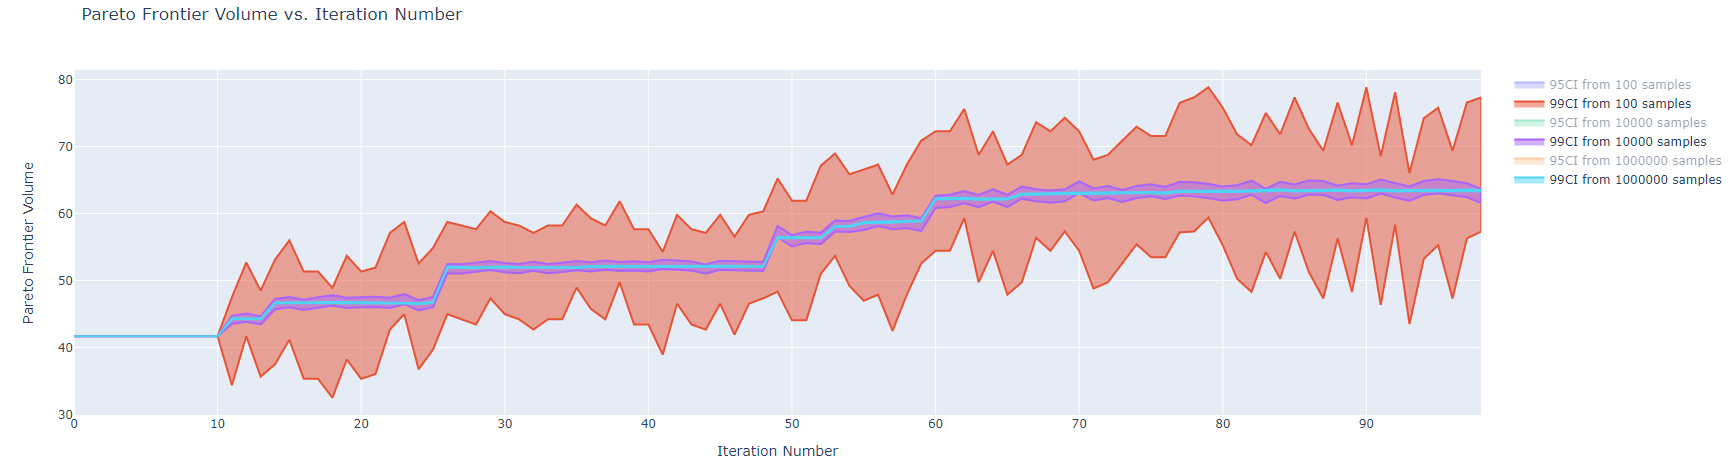

In [11]:
import numpy as np

# Let's create the true pareto frontier so that we can plot it.
#
objective_function.parameter_space.dimensions
theta0 = objective_function.parameter_space['theta0'].linspace(20)
theta1 = objective_function.parameter_space['theta1'].linspace(20)
theta0, theta1 = np.meshgrid(theta0, theta1)
optimum_params_df = pd.DataFrame({
    'theta0': theta0.flatten(),
    'theta1': theta1.flatten(),
})
optimum_params_df['radius'] = hypersphere_radius
optimum_objectives_df = objective_function.evaluate_dataframe(optimum_params_df)
true_pareto_frontier = ParetoFrontier(optimization_problem, optimum_objectives_df)
true_pareto_df = true_pareto_frontier.pareto_df

In [24]:
import plotly.graph_objects as go



# Create figure
fig = go.Figure(
    data=[
        go.Scatter(
            x=objectives_over_time[0]['y0'],
            y=objectives_over_time[0]['y1'],
            mode="markers",
            marker=dict(color="blue", size=10),
            name='observed objectives'
        ),
        go.Scatter(
            x=true_pareto_df['y0'],
            y=true_pareto_df['y1'],
            name='true pareto'
            #mode="markers",
            #marker=dict(color="red", size=10)
        )
    ],
    layout=go.Layout(
        xaxis=dict(range=[0, 10], autorange=False, zeroline=False),
        yaxis=dict(range=[0, 10], autorange=False, zeroline=False),
        title_text="Pareto over time",
        hovermode="closest",
        updatemenus=[dict(type="buttons", buttons=[dict(label="Play", method="animate", args=[None])])],
        width=700,
        height=600
    ),
    frames=[
        go.Frame(
            data=[
                #go.Scatter(
                #    x=true_pareto_df['y0'],
                #    y=true_pareto_df['y1'],
                #    name='true pareto',
                #    mode="lines",
                #    #marker=dict(color="red", size=10)
                #),
                go.Scatter(
                    x=pareto_dfs_over_time[i]['y0'],
                    y=pareto_dfs_over_time[i]['y1'],
                    name='estimated pareto',
                    mode='lines+markers'
                ),
                go.Scatter(
                    x=objectives_over_time[i]['y0'],
                    y=objectives_over_time[i]['y1'],
                    mode="markers",
                    marker=dict(color="blue", size=10),
                    name='observed objectives'
                ),
                
            ]
        )
        for i in objectives_df.index
    ]
)

fig.show()

In [27]:
# We can also compute some speculative pareto I think :)
#
objective_function.parameter_space.dimensions
theta0 = objective_function.parameter_space['theta0'].linspace(60)
theta1 = objective_function.parameter_space['theta1'].linspace(60)
radius = objective_function.parameter_space['radius'].linspace(60)
theta0, theta1, radius = np.meshgrid(theta0, theta1, radius)

params_df = pd.DataFrame({
    'theta0': theta0.flatten(),
    'theta1': theta1.flatten(),
    'radius': radius.flatten()
})


features_df = optimization_problem.construct_feature_dataframe(params_df)
mo_predictions = optimizer.surrogate_model.predict(features_df)

predicted_objectives_df = pd.DataFrame()
for objective_name, prediction in mo_predictions:
    prediction_df = prediction.get_dataframe()
    predicted_objectives_df[objective_name] = prediction_df['predicted_value']

speculative_pareto_df = ParetoFrontier(optimization_problem, predicted_objectives_df).pareto_df
empirical_pareto_df = ParetoFrontier(optimization_problem, objectives_df).pareto_df

In [28]:
import plotly.graph_objects as go

# Create figure
fig = go.Figure(
    data=[
        go.Scatter(
            x=speculative_pareto_df['y0'],
            y=speculative_pareto_df['y1'],
            name='speculative_pareto',
            mode='markers'
        ),
        go.Scatter(
            x=empirical_pareto_df['y0'],
            y=empirical_pareto_df['y1'],
            name='empirical pareto',
            mode='markers'
        ),
        go.Scatter(
            x=true_pareto_df['y0'],
            y=true_pareto_df['y1'],
            name='true pareto'
            #mode="markers",
            #marker=dict(color="red", size=10)
        )
    ],
    layout=go.Layout(
        xaxis=dict(range=[0, 10], autorange=False, zeroline=False),
        yaxis=dict(range=[0, 10], autorange=False, zeroline=False),
        title_text="Pareto over time",
        hovermode="closest",
        width=800,
        height=800
    )
)

fig.show()